# Mouse Peripheral Blood - merging annotated samples from MCA

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import glob

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

results_file = './write/MCA_mou_PB_pp.h5ad'

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)

## Load 
Here we load the pre-processed datasets (which has been annotated), and the raw matrices (which won't be filtered on the gene level). 

### Raw data

In [7]:
file_paths = '../../Munich/datasets/mouse/MCA_PB/'
adatas_raw = []
for i in glob.glob(file_paths+'*.txt.gz'):
    print(i)
    adatas_raw.append(sc.read(i, cache=True)) 

../../Munich/datasets/mouse/MCA_PB/PeripheralBlood6_dge.txt.gz
... reading from cache file cache/..-..-Munich-datasets-mouse-MCA_PB-PeripheralBlood6_dge.h5ad
../../Munich/datasets/mouse/MCA_PB/PeripheralBlood3_dge.txt.gz
... reading from cache file cache/..-..-Munich-datasets-mouse-MCA_PB-PeripheralBlood3_dge.h5ad
../../Munich/datasets/mouse/MCA_PB/PeripheralBlood5_dge.txt.gz
... reading from cache file cache/..-..-Munich-datasets-mouse-MCA_PB-PeripheralBlood5_dge.h5ad
../../Munich/datasets/mouse/MCA_PB/PeripheralBlood2_dge.txt.gz
... reading from cache file cache/..-..-Munich-datasets-mouse-MCA_PB-PeripheralBlood2_dge.h5ad
../../Munich/datasets/mouse/MCA_PB/PeripheralBlood4_dge.txt.gz
... reading from cache file cache/..-..-Munich-datasets-mouse-MCA_PB-PeripheralBlood4_dge.h5ad
../../Munich/datasets/mouse/MCA_PB/PeripheralBlood1_dge.txt.gz
... reading from cache file cache/..-..-Munich-datasets-mouse-MCA_PB-PeripheralBlood1_dge.h5ad


In [9]:
samples = ['PB_6', 'PB_3', 'PB_5', 'PB_2', 'PB_4', 'PB_1']
# Loop to annotate data
for i in range(len(adatas_raw)):
    adata_tmp = adatas_raw[i]
    adata_tmp = adata_tmp.transpose()
    
    #Annotate data
    adata_tmp.obs.index.rename('barcode', inplace=True)
    adata_tmp.obs['batch'] = ['MCA_'+samples[i]]*adata_tmp.n_obs
    adata_tmp.obs['study'] = ['MCA_PB']*adata_tmp.n_obs
    adata_tmp.obs['chemistry'] = ['microwell-seq']*adata_tmp.n_obs
    adata_tmp.obs['tissue'] = ['PB']*adata_tmp.n_obs
    adata_tmp.obs['species'] = ['Mouse']*adata_tmp.n_obs
    adata_tmp.obs['data_type'] = ['UMI']*adata_tmp.n_obs

    adata_tmp.var.index.names = ['gene_symbol']
    adata_tmp.var_names_make_unique()
    adatas_raw[i] = adata_tmp


In [10]:
adatas_raw[0].obs.head()

,batch,study,chemistry,tissue,species,data_type
barcode,,,,,,
PeripheralBlood_6.ACACCCCATCCCCTCCAT,MCA_PB_6,MCA_PB,microwell-seq,PB,Mouse,UMI
PeripheralBlood_6.GAATTAAACGCCGCAGGA,MCA_PB_6,MCA_PB,microwell-seq,PB,Mouse,UMI
PeripheralBlood_6.CACAAGCTGAAAACAATA,MCA_PB_6,MCA_PB,microwell-seq,PB,Mouse,UMI
PeripheralBlood_6.CTCGCATATTGTTCGTAA,MCA_PB_6,MCA_PB,microwell-seq,PB,Mouse,UMI
PeripheralBlood_6.GCAGGAGTTGCCCTGTGT,MCA_PB_6,MCA_PB,microwell-seq,PB,Mouse,UMI


In [11]:
# Concatenate to unique adata object
adata_raw = adatas_raw[0].concatenate(adatas_raw[1:], batch_key='sample_ID', index_unique=None)

In [12]:
adata_raw.obs.head()

,batch,chemistry,data_type,sample_ID,species,study,tissue
barcode,,,,,,,
PeripheralBlood_6.ACACCCCATCCCCTCCAT,MCA_PB_6,microwell-seq,UMI,0,Mouse,MCA_PB,PB
PeripheralBlood_6.GAATTAAACGCCGCAGGA,MCA_PB_6,microwell-seq,UMI,0,Mouse,MCA_PB,PB
PeripheralBlood_6.CACAAGCTGAAAACAATA,MCA_PB_6,microwell-seq,UMI,0,Mouse,MCA_PB,PB
PeripheralBlood_6.CTCGCATATTGTTCGTAA,MCA_PB_6,microwell-seq,UMI,0,Mouse,MCA_PB,PB
PeripheralBlood_6.GCAGGAGTTGCCCTGTGT,MCA_PB_6,microwell-seq,UMI,0,Mouse,MCA_PB,PB


In [13]:
adata_raw.obs.drop(columns=['sample_ID'], inplace=True)
adata_raw.obs.head()

,batch,chemistry,data_type,species,study,tissue
barcode,,,,,,
PeripheralBlood_6.ACACCCCATCCCCTCCAT,MCA_PB_6,microwell-seq,UMI,Mouse,MCA_PB,PB
PeripheralBlood_6.GAATTAAACGCCGCAGGA,MCA_PB_6,microwell-seq,UMI,Mouse,MCA_PB,PB
PeripheralBlood_6.CACAAGCTGAAAACAATA,MCA_PB_6,microwell-seq,UMI,Mouse,MCA_PB,PB
PeripheralBlood_6.CTCGCATATTGTTCGTAA,MCA_PB_6,microwell-seq,UMI,Mouse,MCA_PB,PB
PeripheralBlood_6.GCAGGAGTTGCCCTGTGT,MCA_PB_6,microwell-seq,UMI,Mouse,MCA_PB,PB


In [14]:
adata_raw.shape

(7972, 11348)

### Pre-processed data

In [3]:
file_paths = '../../PB_mouse/MCA/write/'
adatas_pp = []
for i in glob.glob(file_paths+'*.h5ad'):
    print(i)
    adatas_pp.append(sc.read(i, cache=True)) 

../../PB_mouse/MCA/write/MCApb_2.h5ad
../../PB_mouse/MCA/write/MCApb_1.h5ad
../../PB_mouse/MCA/write/MCApb_3.h5ad
../../PB_mouse/MCA/write/MCApb_6.h5ad
../../PB_mouse/MCA/write/MCApb_4.h5ad
../../PB_mouse/MCA/write/MCApb_5.h5ad


In [16]:
for i in range(len(adatas_pp)):
    adata_tmp = adatas_pp[i]
    adata_obs = adata_tmp.obs.reset_index()
    adata_obs = adata_obs[['index', 'final_annotation', 'n_counts', 'n_genes', 'mt_frac']].rename(columns = {'index':'barcode'})
    adata_obs.set_index('barcode', inplace = True)
    adatas_pp[i].obs = adata_obs
    

In [17]:
# Concatenate to unique adata object
adata_pp = adatas_pp[0].concatenate(adatas_pp[1:], batch_key='sample_ID',
                                                        index_unique=None)

In [18]:
adata_pp.obs.drop(columns=['sample_ID'], inplace = True)
adata_pp.obs.head()

,final_annotation,mt_frac,n_counts,n_genes
barcode,,,,
PeripheralBlood_2.ACGTTGTGAAGCATCAAC,Neutrophils,0.005221,5554.0,1808
PeripheralBlood_2.ACACCCGATCTTTGGATG,Neutrophils,0.009034,4317.0,1536
PeripheralBlood_2.CCATCTATCAACTGATCA,Neutrophils,0.012543,6059.0,2095
PeripheralBlood_2.ACCTGACCTTTCAACGCC,Neutrophils,0.009826,5394.0,1927
PeripheralBlood_2.CTCGCAATCTCTGAATTA,Neutrophils,0.006378,4233.0,1409


In [19]:
adata_raw.shape

(7972, 11348)

In [20]:
adata_pp.shape

(7576, 3414)

In [21]:
# Restrict to cells that passed QC and were annotated
adata_obs_raw = adata_raw.obs.reset_index()
adata_obs_pp = adata_pp.obs.reset_index()
adata_merged = adata_obs_raw.merge(adata_obs_pp, on='barcode', how='left')
adata_merged.set_index('barcode', inplace = True)
adata_raw.obs = adata_merged
adata_raw.obs.head()

,batch,chemistry,data_type,species,study,tissue,final_annotation,mt_frac,n_counts,n_genes
barcode,,,,,,,,,,
PeripheralBlood_6.ACACCCCATCCCCTCCAT,MCA_PB_6,microwell-seq,UMI,Mouse,MCA_PB,PB,NaN,NaN,NaN,NaN
PeripheralBlood_6.GAATTAAACGCCGCAGGA,MCA_PB_6,microwell-seq,UMI,Mouse,MCA_PB,PB,NaN,NaN,NaN,NaN
PeripheralBlood_6.CACAAGCTGAAAACAATA,MCA_PB_6,microwell-seq,UMI,Mouse,MCA_PB,PB,NaN,NaN,NaN,NaN
PeripheralBlood_6.CTCGCATATTGTTCGTAA,MCA_PB_6,microwell-seq,UMI,Mouse,MCA_PB,PB,CD20+ B cells,0.017783,1687.0,870.0
PeripheralBlood_6.GCAGGAGTTGCCCTGTGT,MCA_PB_6,microwell-seq,UMI,Mouse,MCA_PB,PB,CD20+ B cells,0.017013,1587.0,799.0


In [22]:
adata_raw = adata_raw[~pd.isnull(adata_raw.obs['final_annotation'])]
adata_raw.shape

(7576, 11348)

### Normalization

In [23]:
# Exclude genes that are = 0 in all cells
#Filter genes:
print('Total number of genes: {:d}'.format(adata_raw.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_raw, min_cells=1)
print('Number of genes after cell filter: {:d}'.format(adata_raw.n_vars))

Total number of genes: 11348
filtered out 2 genes that are detectedin less than 1 cells


Trying to set attribute `.var` of view, making a copy.


Number of genes after cell filter: 11346


In [24]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata_raw.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [25]:
# Check if the minimum number of cells per cluster is < 21:in that case, sizes will be also passed as input to the normalization
adata_pp.obs['groups'].value_counts()

0     1493
1     1277
2     1195
3     1110
4      583
5      502
6      428
7      385
8      356
9      155
10      92
Name: groups, dtype: int64

In [26]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata_raw.X.T

In [27]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [28]:
#Delete adata_pp
del adata_pp

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'final_annotation' as categorical


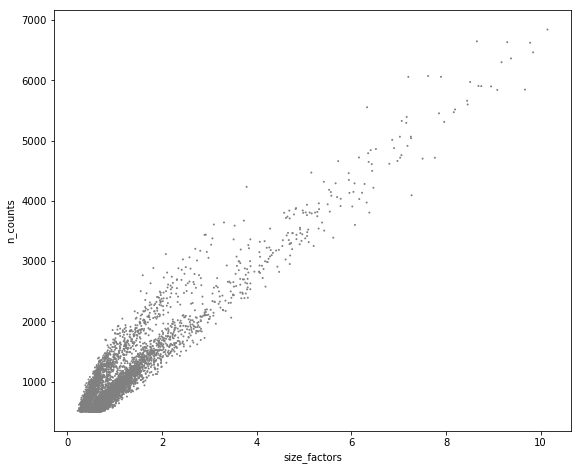

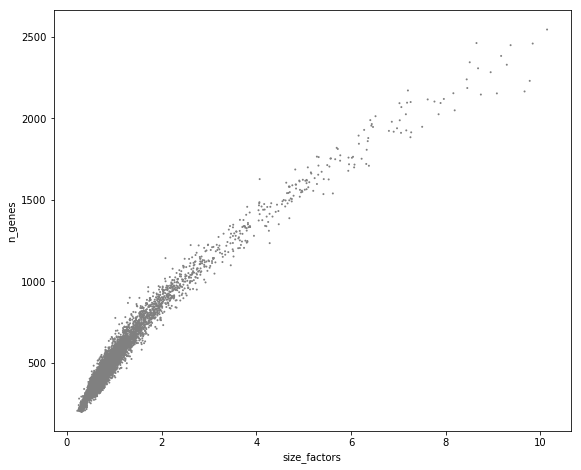

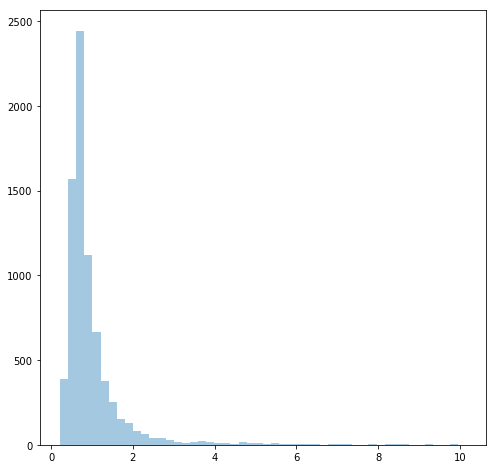

In [29]:
# Visualize the estimated size factors
adata_raw.obs['size_factors'] = size_factors

sc.pl.scatter(adata_raw, 'size_factors', 'n_counts')
sc.pl.scatter(adata_raw, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [31]:
#Keep the count data in a counts layer
adata_raw.layers["counts"] = adata_raw.X.copy()

In [32]:
#Normalize adata 
adata_raw.X /= adata_raw.obs['size_factors'].values[:,None]
sc.pp.log1p(adata_raw)

In [33]:
adata_raw.write(results_file)